In [1]:
using LinearAlgebra
using Plots
using RefractiveIndex, Unitful
using LaTeXStrings


In [2]:
TiO2 = RefractiveMaterial("https://refractiveindex.info/?shelf=main&book=TiO2&page=Devore-o")
Au=RefractiveMaterial("https://refractiveindex.info/?shelf=main&book=Au&page=Johnson")
BK7=RefractiveMaterial("https://refractiveindex.info/?shelf=glass&book=BK7-Schott&page=Lane")
Cr=RefractiveMaterial("https://refractiveindex.info/?shelf=main&book=Cr&page=Johnson")

Cr (Johnson and Christy 1974: n,k 0.188–1.937 µm) - TabulatedNK

In [3]:
function n_m(m,λ) #λ in nm     
    dispersion(m,Float64(λ*1e-3))
end


n_m (generic function with 1 method)

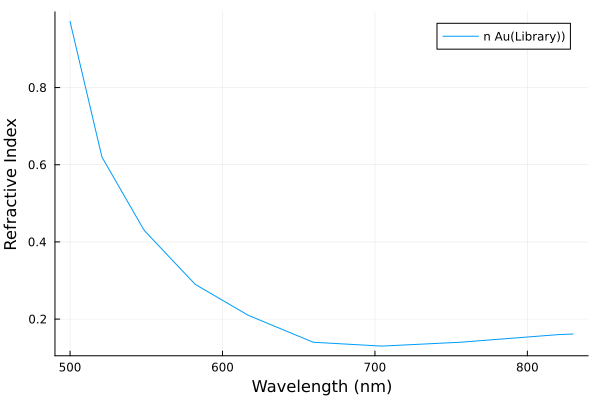

In [100]:
plot(lambda,real.(n_m.(Ref(Au),lambda)),label="n Au(Library))",xlabel="Wavelength (nm)",ylabel="Refractive Index",legend=:topright)
#plot!(lambda,real.(nAu),label="n Au",xlabel="Wavelength (nm)",ylabel="Refractive Index",legend=:topright)


In [4]:

# -------------------------------
# Parameters
# -------------------------------

N = 1                # number of thin films (intermediate layers)
pol = 0               # polarization: 0 = TM, 1 = TE
lam_ini = 500.0       # initial wavelength [nm]
lam_fin = 830.0       # final wavelength [nm]
ang_ini = 0.0         # initial incidence angle [deg]
ang_fin = 80.0        # final incidence angle [deg]
nsub = 1.515            # substrate refractive index
noil1 = 1.512
nsup = 1.0            # superstrate refractive index
d = [0.001,3,30]            # thickness of each thin film [nm] [0.1,3,30]

# -------------------------------
# Wavelength and angle grids
# -------------------------------
lambda=lam_ini:1.0:lam_fin
lam = ComplexF64.(lambda)  #λ
k0 = 2π ./ lam
ang_inc = ang_ini:0.1:ang_fin
ang = deg2rad.(ang_inc)

z0 = 0#zeros(Float64, N+1)
z=cumsum(d)
prepend!(z,z0)'
#for k in 1:N
#    z[k+1] = z[k] + d[k]
#end

# -------------------------------
# Refractive indices
# -------------------------------
nTiO2 = n_m.(Ref(TiO2),lambda) ###May be differnet from constant value
n0 = fill(nsub, length(lam))
nCr = n_m.(Ref(Cr),lambda) 
nend = fill(nsup, length(lam))
noil=fill(noil1,length(lam))


# -------------------------------
# Drude–Lorentz model for gold
# A. Vial et al.
# -------------------------------
c = 2.99792458e8                      # speed of light [m/s]
w = 2π * c ./ (lam .* 1e-9)
epsL_inf = 5.9673
wD = 2π * 2113.6e12
gD = 2π * 15.92e12
omegaL = 2π * 650.07e12
GL = 2π * 104.86e12
Deps = 1.09
#-------------------------------------
# Calculate refractive index of gold
#-------------------------------------
epsAu = ComplexF64[] #Gold ϵ
for k in eachindex(lam)
    push!(epsAu, epsL_inf - (wD^2) / (w[k] * (w[k] + 1im*gD))
          - (Deps * omegaL^2) / ((w[k]^2 - omegaL^2) + 1im*GL*w[k]))
end
nAu = sqrt.(epsAu)

# Construct refractive index matrix
nref = transpose([n0 noil nCr nAu nend])  # (3 × Nλ) [n0 nAu nTiO2 nend]' ###

# -------------------------------
# Reflectance and Transmittance
# -------------------------------
Rf = zeros(length(lam), length(ang))
Tr = zeros(length(lam), length(ang))

for (ii, λ) in enumerate(lam) # For every Wvelength
    for (jj, θ) in enumerate(ang)####For every angle 
        T = Matrix{ComplexF64}(I, 2, 2)
        #rf = Matrix{ComplexF64}(I, 2, 2)
        b2 = k0[ii] * nsub * sin(θ)

        for kk in 1:length(z)
            aj = sqrt(k0[ii]^2 * nref[kk, ii]^2 - b2^2)
            aj1 = sqrt(k0[ii]^2 * nref[kk+1, ii]^2 - b2^2)

            if pol == 0
                nuj, nuj1 = nref[kk, ii]^2, nref[kk+1, ii]^2
            else
                nuj, nuj1 = 1.0, 1.0
            end

            kj = (aj * nuj1) / (aj1 * nuj)
            a11 = (1 + kj) * exp(1im * (aj - aj1) * z[kk])
            a12 = (1 - kj) * exp(-1im * (aj + aj1) * z[kk])
            a21 = (1 - kj) * exp(1im * (aj + aj1) * z[kk])
            a22 = (1 + kj) * exp(-1im * (aj - aj1) * z[kk])
            Tj = 0.5 * [a11 a12; a21 a22]
            T= Tj*T
            #println(Tj)
            #println(a11)
            #println(kk)
        end
        rf = -T[2,1] / T[2,2]
        Rf[ii, jj] = abs2(rf)
        Tr[ii, jj] = 1 - Rf[ii, jj]
        
    end
end
#This was run on linux 


AngC = asin(nsup/nsub) * 180/π
ThetaC = fill(AngC, length(lam))
RfAux = range(0, 1, length(lam))

0.0:0.0030303030303030303:1.0

In [85]:
Rfconstant=Rf;
Trconstant=Tr;

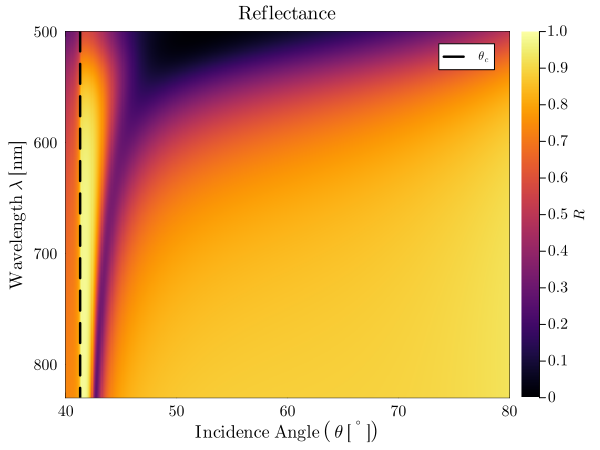

In [5]:


# Example data (replace with your real arrays)
# ang_inc = ...
# lam = ...
# Rf = ...
# ThetaC = ...

# --- General plotting style ---
default(
    framestyle = :box,
    legend = :topright,
    guidefont = font(12, "Computer Modern"),
    tickfont = font(10, "Computer Modern"),
    titlefont = font(13, "Computer Modern"),
    grid = false,
    size = (600, 450)
)

# --- Heatmap plot ---
p1 = heatmap(
    ang_inc,
    real.(lam),
    Rf;
    xlabel = L"\mathrm{Incidence\ Angle\ }\left(\theta\ [^\circ]\right)",
    ylabel = L"\mathrm{Wavelength\ }\lambda\ [\mathrm{nm}]",
    title = L"\mathrm{Reflectance}",
    colorbar_title = L"R",
    color = :inferno,
    ylim = (lam_ini, lam_fin),
    xlim = (40, ang_fin),
    yflip = true,
    aspect_ratio = 0.1,          # ⟵ adjust this           # ⟵ bigger and proportioned
    clims = (0, 1),
    framestyle = :box
)


# --- Add critical angle trace ---
vline!(
    p1,
    [ThetaC[1]],
    lw = 2.5,
    lc = :black,
    ls = :dash,
    label = L"\theta_c"
)

# --- Final adjustments ---
#annotate!(
#    0.85 * ang_fin, lam_ini + 0.05*(lam_fin - lam_ini),
#    text(L"\mathrm{TiO_2\ Interface}", 10, :white, :right)
#)

savefig("ReflectanceMap.svg")
display(p1)


In [6]:
RF=transpose(Rf)
Θ= repeat(ang_inc, 1, length(lam));



In [13]:
using Pkg

In [16]:
using Colors

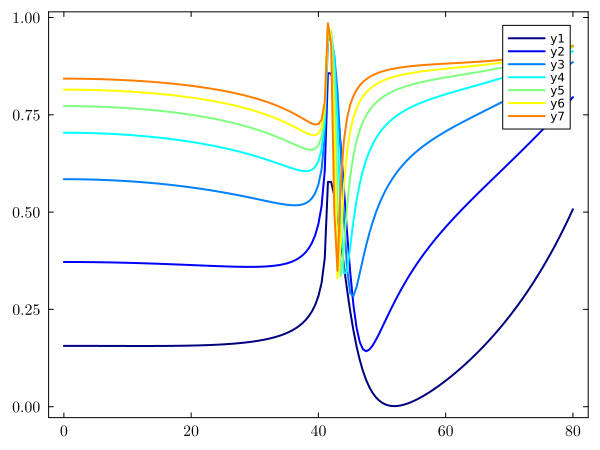

In [40]:
sλ=50
sθ =5
# Get colors from a spectrum-like colormap
plot(Θ[1:sθ:end, 1:sλ:end], RF[1:sθ:end, 1:sλ:end], 
     palette = :jet,lw=2)  # or :jet, :turbo)

In [71]:
n=700-380

320

In [81]:
colors = cgrad(:turbo, n, categorical=true)

In [82]:
lam_ini

500.0

In [83]:
colors[Int(lam_ini)-380]

In [100]:
string(1)

"1"

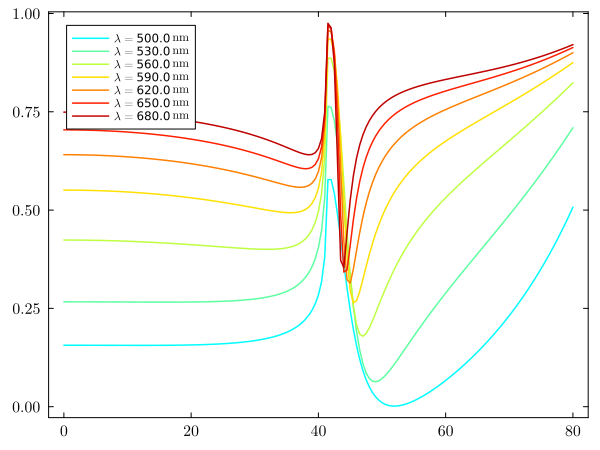

In [113]:
# Create a discrete color palette with n colors
Δλ =30
# Now plot using integer indices
pp = plot(legend=true)
for i in 1:Δλ:200#length(lam) up to 700 nm
    plot!(pp, Θ[1:sθ:end, i], RF[1:sθ:end, i], 
          color = colors[Int.(lam[i])-380],  # Direct integer indexing
          lw = 1.5,label = L"\lambda = "* string(real(lam[i])) * L"\ \mathrm{nm}"
)
end
display(pp)

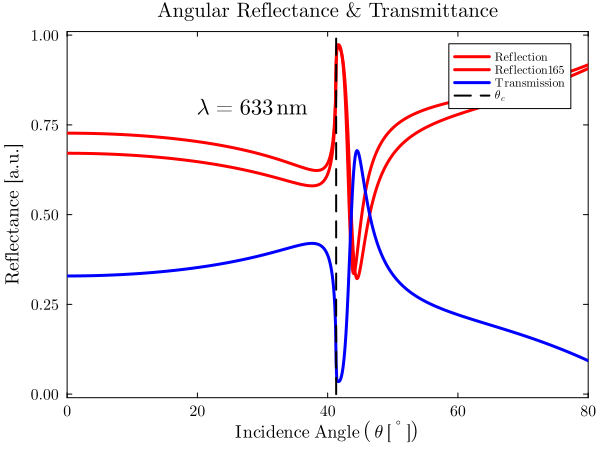

In [246]:
# Reflectance and Transmittance at specific λ
Nlam = 134
p2 = plot(ang_inc, Rf[Nlam, :], lw=3, label=L"\mathrm{Reflection}", color=:red,ylims=(-0.01, 1.01),xlims=(ang_ini, ang_fin))
plot!(ang_inc, Rf[165, :], lw=3, label=L"\mathrm{Reflection 165}", color=:red,ylims=(-0.01, 1.01),xlims=(ang_ini, ang_fin))
plot!(ang_inc, Tr[Nlam, :], lw=3, label=L"\mathrm{Transmission}", color=:blue)
plot!(ThetaC, RfAux, lw=2, ls=:dash, color=:black, label=L"\theta_c")
xlabel!(L"\mathrm{Incidence\ Angle\ }\left(\theta\ [^\circ]\right)")
ylabel!("Reflectance [a.u.]")
#ylim!(-0.01, 1.01)
#xlim!(ang_ini, ang_fin)
plot!(legend=:topright, title="Angular Reflectance & Transmittance")
annotate!(37, 0.8, 
    text(L"\lambda = 633\,\mathrm{nm}", 15, :black, :right)
)
savefig("Reflectancevsangle.svg")
display(p2)

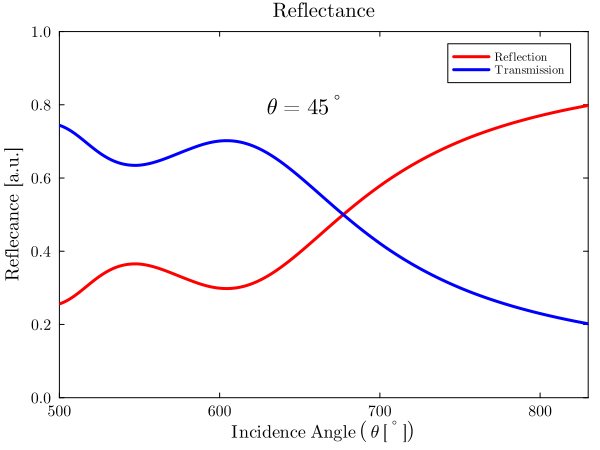

In [226]:
Nlam = 165#134
p3=plot(lambda, Rf[:, 450], lw=3, label=L"\mathrm{Reflection}", color=:red,xlims=(lam_ini, lam_fin),ylims=(0,1))
plot!(lambda, Tr[:, 450], lw=3, label=L"\mathrm{Transmission}", color=:blue,xlims=(lam_ini, lam_fin),ylims=(0,1))
#plot!(ang_inc, Tr[Nlam, :], lw=3, label=L"\mathrm{Transmission}", color=:blue)
#plot!(ThetaC, RfAux, lw=2, ls=:dash, color=:black, label=L"\theta_c")
xlabel!(L"\mathrm{Incidence\ Angle\ }\left(\theta\ [^\circ]\right)")
ylabel!("Reflecance [a.u.]")
#ylim!(-0.01, 1.01)
#xlim!(ang_ini, ang_fin)
plot!(legend=:topright, title="Reflectance")
annotate!(680, 0.8, 
    text(L"\theta=45^\circ", 15, :black, :right)
)
savefig("Reflectancevslambda.svg")
display(p3)


In [ ]:
plot(ang_inc, Rf[Nlam, :], lw=3, label=L"\mathrm{Reflection}", color=:red,ylims=(-0.01, 1.01),xlims=(ang_ini, ang_fin))

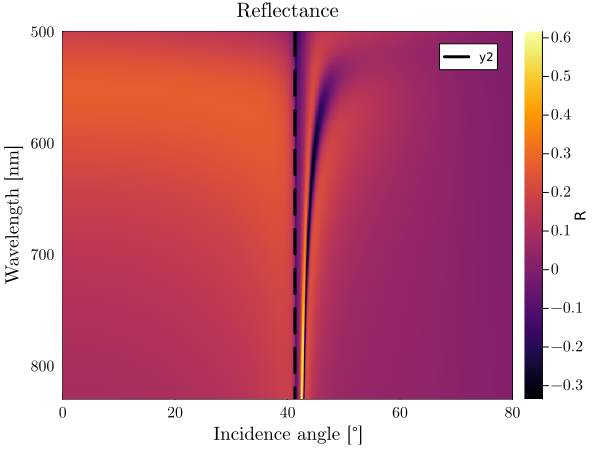

In [158]:
p1 = heatmap(ang_inc, real.(lam), Rfconstant.-Rf;
    xlabel="Incidence angle [°]",
    ylabel="Wavelength [nm]",
    title="Reflectance",
    colorbar_title="R",
    ylim=(lam_ini, lam_fin),
    xlim=(ang_ini, ang_fin),
    yflip=true)
plot(p1, ThetaC, real.(lam), lw=3, lc=:black, ls=:dash)

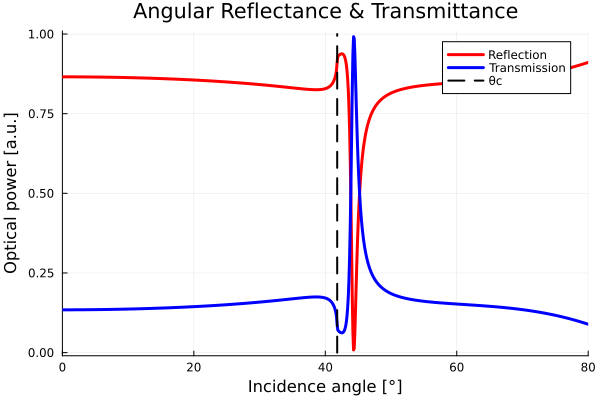

In [74]:
# Reflectance and Transmittance at specific λ
Nlam = 134
p2 = plot(ang_inc, Rfconstant[Nlam, :], lw=3, label="Reflection", color=:red,ylims=(-0.01, 1.01),xlims=(ang_ini, ang_fin))
plot!(ang_inc, Trconstant[Nlam, :], lw=3, label="Transmission", color=:blue)
plot!(ThetaC, RfAux, lw=2, ls=:dash, color=:black, label="θc")
xlabel!("Incidence angle [°]")
ylabel!("Optical power [a.u.]")
#ylim!(-0.01, 1.01)
#xlim!(ang_ini, ang_fin)
plot!(legend=:topright, title="Angular Reflectance & Transmittance")

#display(p1)
#display(p2)

In [10]:
Matrix{ComplexF64}(I, 2, 2)

2×2 Matrix{ComplexF64}:
 1.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im

In [28]:
z0 = 0#zeros(Float64, N+1)
z=cumsum(d)
prepend!(z,z0)'

1×2 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  50.0

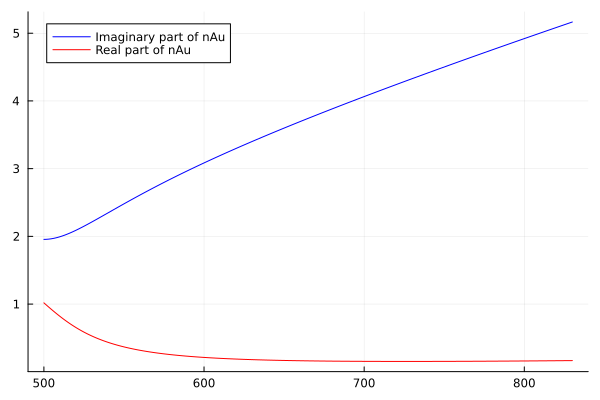

In [35]:
plot(real(lam),imag(nAu),color=:blue, label="Imaginary part of nAu")
plot!(real(lam),real(nAu),color=:red, label="Real part of nAu")

In [22]:
z

2-element Vector{Float64}:
  0.0
 50.0

In [52]:
Matrix{ComplexF64}(I, 2, 2)

2×2 Matrix{ComplexF64}:
 1.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im

In [40]:
real(sqrt.(abs.(nAu)))[end]

2.2734104857959063